In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [10]:
def show_batch_img(batch_x, batch_y=None, ncols=5, type_flag=0, mult=3, suptitle=None):
    count_ = batch_x.size(0)
    nrows = math.ceil(count_/ncols)
    
    fig, ax = plt.subplots(
        figsize=(16,mult*nrows),ncols=ncols, nrows=nrows, sharex=True, sharey=True);
    if suptitle:
        fig.suptitle(suptitle, fontsize=30)
    ax = [axij for axi in ax for axij in axi]
    for i, img in enumerate(batch_x):
        if batch_y != None:
            title = dataset.classes[batch_y[i]]
        else:
            title = None
        ax[i]
        show_img(img, title=title, ax_flag=ax[i], type_flag=type_flag)
    for axi in ax[i+1:]:
        axi.remove()

def get_counts_by_class(dataset, subset=None):
    if subset:
        class_counts = collections.Counter(
            np.array(dataset.targets)[subset.indices])
    else:
        class_counts = collections.Counter(dataset.targets)
    df_classes = pd.DataFrame.from_dict(class_counts, orient='index').merge(
        pd.DataFrame.from_dict(dataset.class_to_idx, orient='index'),
        left_index=True,
        right_on=0,
        how="inner"
    ).drop(columns=["key_0", "0_y"]).reset_index()
    df_classes.columns=["name", "count"]
    return df_classes

def barplot_(df_classes, figsize=(20,3), fnt_x=20,
             title="Количество экземпляров каждого вида птиц в датасете"):
    cmap = sns.color_palette("light:#5A9", as_cmap=True)
    plt.figure(figsize=figsize)
    sns.barplot(x=df_classes["name"], y=df_classes["count"], palette="dark");
    plt.xticks(rotation = 'vertical', fontsize=fnt_x);
    plt.xlabel("Название вида птиц", fontsize=20)
    plt.ylabel("Количество\nэкземпляров", fontsize=20)
    plt.title(title, fontsize=25)
    plt.show()

def show_img(image, title=None, figsize=(3,3), ax_flag=None, type_flag=0):
    std_, mean_ = std.to(device), mean.to(device)
    if not ax_flag:
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        ax = ax_flag
    if title:
        ax.set_title(title)
    if type_flag == 0:
        image_ = (image * std_.view(-1, 1, 1)) + mean_.view(-1, 1, 1)
        image_ = image_.cpu().detach().numpy()
        image_ = np.transpose(image_, (1, 2, 0))
    elif type_flag == 1:
        image_ = (image - image.min()) / (image.max()-image.min())
        image_ = image_.cpu().detach().numpy()
    ax.imshow(image_, cmap="Greys")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if not ax_flag:
        plt.show()
    
def get_subset_indexes(dataset, count_ = 400, classes_count=5):
    targets = np.array(dataset.targets)
    subset_indexes = np.empty(0, dtype=np.int32)
    
    for i in range(classes_count):
        samples = np.random.choice(
            np.where(targets == i)[0],
            size=count_,
            replace=False)
        subset_indexes = np.concatenate((subset_indexes, samples))
    return subset_indexes


def get_metrics(y_true, y_pred, average="weighted", zero_division=0):
    y_true, y_pred = y_true.cpu(), y_pred.cpu()
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,
                              average=average, zero_division=zero_division)
    recall = recall_score(y_true, y_pred,
                        average=average, zero_division=zero_division)
    f1 = f1_score(y_true, y_pred,
                average=average, zero_division=zero_division)
    return acc, precision, recall, f1

def train(model, train_dl, optimizer, criterion):
    model.train()
    train_loss = 0
    y_true = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)

    for inputs, targets in tqdm(train_dl, leave=False, desc='train'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pred_ = torch.max(outputs, 1)[1]
        y_true = torch.cat((y_true, targets))
        y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, train_loss

def test(model, test_dl, criterion):
    model.eval()
    test_loss = 0
    y_true = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)
    with torch.no_grad():
        for inputs, targets in tqdm(test_dl, leave=False, desc='test'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())

            test_loss += loss.item()
            pred_ = torch.max(outputs, 1)[1]
            y_true = torch.cat((y_true, targets))
            y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, test_loss

def results_df(params=None):
    return pd.DataFrame(
        data=params,
        columns=["epoch", "type", *metrics__],
    ).set_index(["epoch", "type"])
    

def train_model(model, train_dl, test_dl, optimizer, criterion, num_epochs=10,
                patience=2, early_stopping=3, factor=0.2):
    start_time = time()
    results = results_df()
    previous = 9999999999
    best_epoch = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=patience, factor=factor,
        verbose=True, min_lr=0.000001)
    
    for epoch in range(num_epochs):
        y_true, y_pred, train_loss = train(model, train_dl, optimizer, criterion)
        
        temp = [[epoch, "train", train_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))
        
        y_true, y_pred, validation_loss = test(model, validation_dl, criterion)
        
        temp = [[epoch, "validation", validation_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))
        
        val_acc = results.loc[(epoch, 'validation'), 'accuracy']
        if previous-validation_loss > 0.001:
            previous = validation_loss
            best_epoch = epoch
            print(f"epoch {epoch+1}: model saved")
            torch.save(model.state_dict(), "temp.pth")
        else:
            if epoch - best_epoch > early_stopping:
                break
                
        scheduler.step(validation_loss)
        print(f"\r#Эпоха [{epoch+1:2}]: train loss [{train_loss:.4f}],",
              f"validation loss [{validation_loss:.4f}],",
              f"train accuracy [{results.loc[(epoch, 'train'), 'accuracy']:.4f}],",
              f"validation accuracy [{val_acc:.4f}]")
        
    model.load_state_dict(torch.load("temp.pth"))

    time_ = time()-start_time
    print(f"time: {time_/60:.2f} minutes")
    return results, time_

def plot_metric(result_df, type_="loss", ax_flag=None,
                figsize=(14,5), fontsize=16, show_ylabel=True,
                title=False, show_xlabel=True, twinx=False):
    if not ax_flag:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = ax_flag
    xs = pd.IndexSlice
    plt1, = ax.plot(
        result_df.loc[xs[:,"train"], type_].values,
        label=f"train {type_}",
        color="#F3A505",
        linewidth = 3)
    if twinx:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    plt2, = ax2.plot(
        result_df.loc[xs[:,"validation"], type_].values,
        label=f"validation {type_}",
        color="#2E8B57",
        linewidth = 3)
    if title:
        ax.set_title(type_)
    ax.legend(handles=[plt1, plt2], fontsize=fontsize)
    
    if show_xlabel:
        ax.set_xlabel("Номер эпохи", fontsize=fontsize)
    if show_ylabel:
        ax.set_ylabel(type_, fontsize=fontsize, rotation=90)
    ax.grid(which="both", color="#d0d0d0", linestyle="dashed")
    if not ax_flag:
        plt.show()
        
def plot_metrics(result_df, figsize=(18,10), fontsize=10, title=True):
    fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=2, sharex=True)
    ax = [axij for axi in ax for axij in axi]
    ax[-1].remove()
    for i, type_ in enumerate(metrics__[:0:-1]):     
        plot_metric(result_df[0], type_=type_, ax_flag=ax[i], show_xlabel=False,
                    fontsize=fontsize, show_ylabel=False, title=True)
    plot_metric(result_df[0], type_=metrics__[0], ax_flag=ax[i+1], show_xlabel=False,
                    fontsize=fontsize, show_ylabel=False, title=True, twinx=True)

def heatmap_(y_true, y_pred, classes=None, fontsize=12, figsize=(14,10)):
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap='Greens');
    if classes:
        x = np.unique(y_true).astype("int")
        x.sort()
        classes = np.array(classes)[x]
        heatmap.set_yticklabels(classes, rotation = 0, fontsize = fontsize)
        heatmap.set_xticklabels(classes, rotation =90, fontsize = fontsize);
    plt.show()
    
def show_layers_result(iter_, layers_count=3):
    for xi, yi in test_dl:
        ind = random.randint(0, xi.size(0)-1)
        show_img(xi[ind], title=dataset.classes[yi[ind]])
        xi_xurr = xi
        for i in range(layers_count):
            layer = next(iter_)
            xi_sub = layer(xi_xurr)
            show_batch_img(xi_sub[ind], ncols=8, mult=2,
                           type_flag=1, suptitle=f"{i+1} layer")
            xi_xurr = xi_sub
        break

In [2]:
import os
import math
import torch
import pickle
import random
import zipfile
import torchvision
import collections
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = os.getcwd()
birds_path = os.path.join(root, "birds")
metrics__ = ["loss", "accuracy", "precision", "recall", "f1"]


mean = torch.tensor((0.485, 0.456, 0.406))
std = torch.tensor((0.229, 0.224, 0.225))
img_size = (224, 224)
transform =transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
#     transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.Normalize(mean=mean, std=std),
])
dataset = datasets.ImageFolder(birds_path, transform=transform)
subset = Subset(dataset, get_subset_indexes(dataset, count_=600, classes_count=10))

train_set, validation_set, test_set =  random_split(subset.indices, [0.6, 0.2, 0.2])

train_set = Subset(dataset, train_set.dataset[train_set.indices])
validation_set = Subset(dataset, validation_set.dataset[validation_set.indices])
test_set = Subset(dataset, test_set.dataset[test_set.indices])

batch_size = 32
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [29]:
with open('sets.pkl', 'rb') as fp:
    train_set = pickle.load(fp)
    validation_set = pickle.load(fp)
    test_set = pickle.load(fp)
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [7]:
effnet_b0_1 = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet_b0_1.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.45),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.45),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)
effnet_b0_1 = effnet_b0_1.to("cpu")
for param in effnet_b0_1.parameters():
    param.requires_grad = False
for param in effnet_b0_1.classifier.parameters():
    param.requires_grad = True
    
learnin_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_b0_1.parameters(), lr=learnin_rate)

In [9]:
#загрузка имеющихся результатов (по необходимости)
with open('efficientnet_b0_1.pkl', 'rb') as fp:
    results1 = pickle.load(fp)
effnet_b0_1 = torch.load('efficientnet_b0_1.pth')

In [30]:
y_true, y_pred, loss = test(effnet_b0_1, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()

test:   0%|          | 0/38 [00:00<?, ?it/s]

In [38]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

                       precision    recall  f1-score   support

Asian Green Bee-Eater       0.86      0.93      0.89       111
  Brown-Headed Barbet       0.74      0.79      0.77       121
         Cattle Egret       0.94      0.96      0.95       123
    Common Kingfisher       0.96      0.91      0.93       125
          Common Myna       0.93      0.95      0.94       116
     Common Rosefinch       0.80      0.79      0.79       129
    Common Tailorbird       0.84      0.80      0.82       124
   Coppersmith Barbet       0.83      0.78      0.81       117
       Forest Wagtail       0.88      0.90      0.89       125
         Gray Wagtail       0.90      0.86      0.88       109

             accuracy                           0.87      1200
            macro avg       0.87      0.87      0.87      1200
         weighted avg       0.87      0.87      0.87      1200



In [35]:
#загрузка имеющихся результатов
with open('efficientnet_b0_2.pkl', 'rb') as fp:
    results2 = pickle.load(fp)
effnet_b0_2 = torch.load('efficientnet_b0_2.pth')

In [39]:
#загрузка имеющихся результатов
with open('efficientnet_b0_3.pkl', 'rb') as fp:
    results3 = pickle.load(fp)
effnet_b0_3 = torch.load('efficientnet_b0_3.pth')

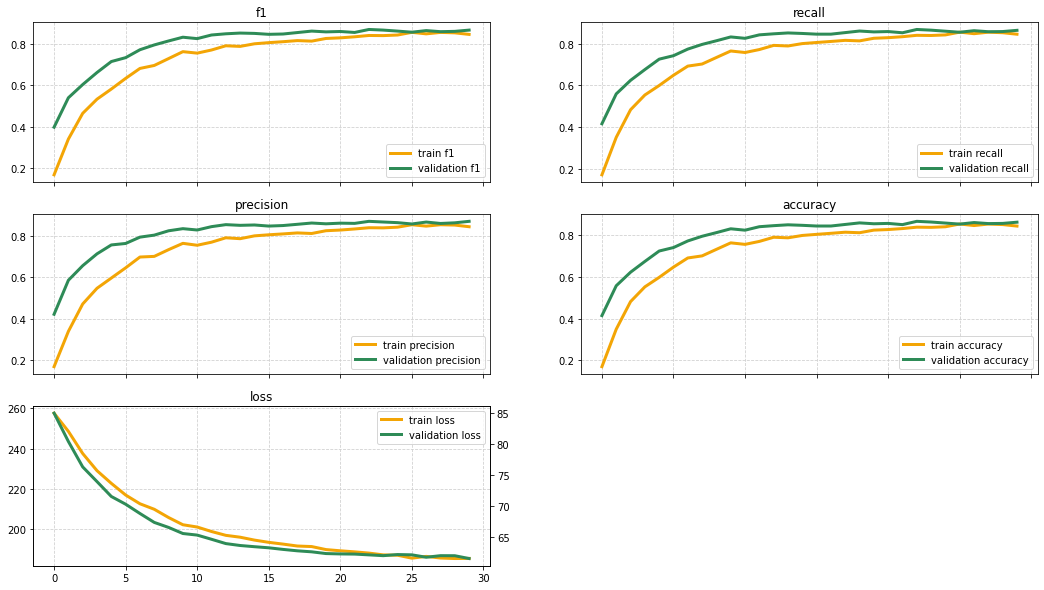

In [40]:
plot_metrics(results3)

In [41]:
y_true, y_pred, loss = test(effnet_b0_3, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()

test:   0%|          | 0/38 [00:00<?, ?it/s]

In [42]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

                       precision    recall  f1-score   support

Asian Green Bee-Eater       0.91      0.90      0.90       111
  Brown-Headed Barbet       0.68      0.84      0.75       121
         Cattle Egret       0.95      0.94      0.95       123
    Common Kingfisher       0.95      0.88      0.91       125
          Common Myna       0.94      0.93      0.94       116
     Common Rosefinch       0.86      0.74      0.80       129
    Common Tailorbird       0.82      0.82      0.82       124
   Coppersmith Barbet       0.75      0.84      0.79       117
       Forest Wagtail       0.92      0.86      0.89       125
         Gray Wagtail       0.94      0.88      0.91       109

             accuracy                           0.86      1200
            macro avg       0.87      0.86      0.87      1200
         weighted avg       0.87      0.86      0.87      1200



In [8]:
effnet_b0_1.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=128, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.45, inplace=False)
  (4): Linear(in_features=128, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.45, inplace=False)
  (8): Linear(in_features=256, out_features=10, bias=True)
  (9): Softmax(dim=1)
)

In [11]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [9]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [13]:
# Walk through each directory
dataset = "./birds"
walk_through_dir(dataset)

There are 25 directories and 0 images in './birds'.
There are 0 directories and 924 images in './birds\Asian Green Bee-Eater'.
There are 0 directories and 924 images in './birds\Brown-Headed Barbet'.
There are 0 directories and 918 images in './birds\Cattle Egret'.
There are 0 directories and 924 images in './birds\Common Kingfisher'.
There are 0 directories and 926 images in './birds\Common Myna'.
There are 0 directories and 919 images in './birds\Common Rosefinch'.
There are 0 directories and 918 images in './birds\Common Tailorbird'.
There are 0 directories and 778 images in './birds\Coppersmith Barbet'.
There are 0 directories and 924 images in './birds\Forest Wagtail'.
There are 0 directories and 926 images in './birds\Gray Wagtail'.
There are 0 directories and 924 images in './birds\Hoopoe'.
There are 0 directories and 924 images in './birds\House Crow'.
There are 0 directories and 922 images in './birds\Indian Grey Hornbill'.
There are 0 directories and 919 images in './birds\In

In [31]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)
image_df = image_df.drop_duplicates()

In [32]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

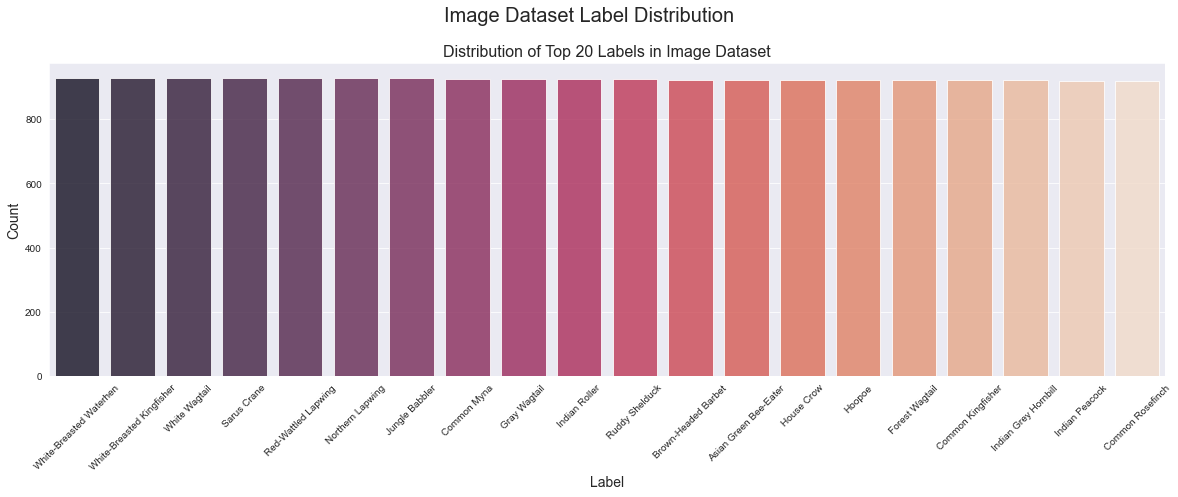

In [33]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()[:20]

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket', ax=axes)
axes.set_title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

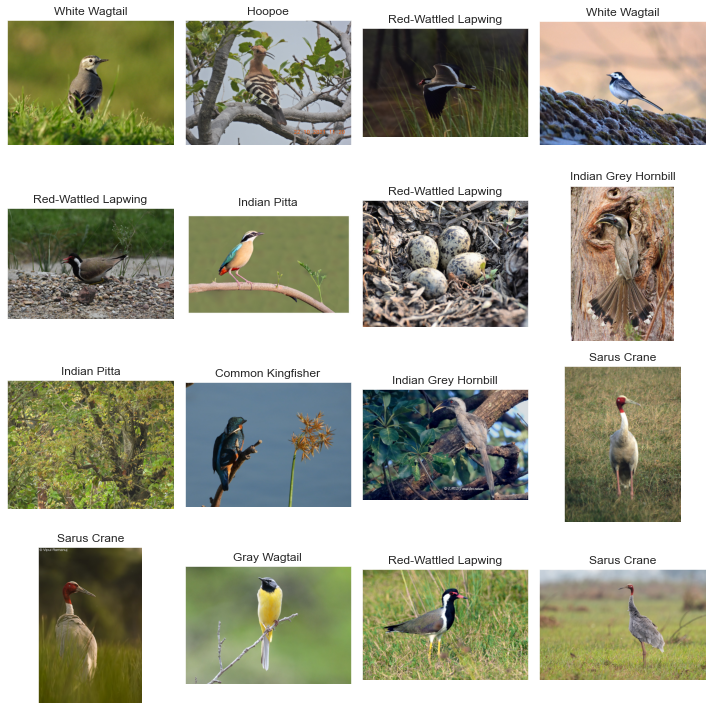

In [34]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [35]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

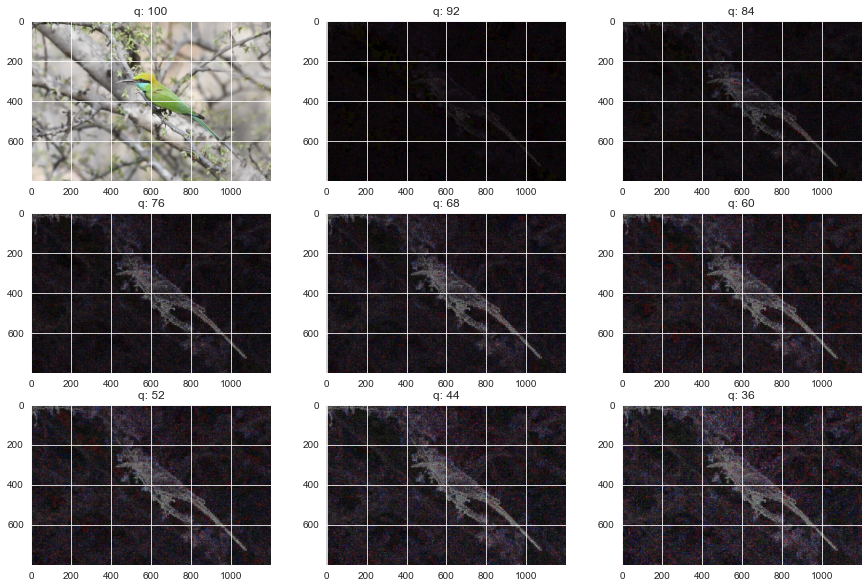

In [38]:
p = random_sample('./birds/Asian Green Bee-Eater')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [39]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [40]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [41]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14477 validated image filenames belonging to 25 classes.
Found 3619 validated image filenames belonging to 25 classes.
Found 4524 validated image filenames belonging to 25 classes.


In [47]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.experimental.preprocessing.RandomFlip("horizontal"),
#   layers.experimental.preprocessing.RandomRotation(0.1),
#   layers.experimental.preprocessing.RandomZoom(0.1),
#   layers.experimental.preprocessing.RandomContrast(0.1),
])

In [48]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [49]:
checkpoint_path = "indian_birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [50]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(25, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=90,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "indian_birds_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/indian_birds_classification/20230416-151135
Epoch 1/90
453/453 [==============================] - 486s 1s/step - loss: 4.1717 - accuracy: 0.0684 - val_loss: 2.7794 - val_accuracy: 0.2012 - lr: 1.0000e-05
Epoch 2/90
453/453 [==============================] - 476s 1s/step - loss: 3.4742 - accuracy: 0.1382 - val_loss: 2.1801 - val_accuracy: 0.3902 - lr: 1.0000e-05
Epoch 3/90
 30/453 [>.............................] - ETA: 5:52 - loss: 3.2528 - accuracy: 0.1490

KeyboardInterrupt: 

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 